# Data, bias and variance

- __Prerequisites__: [Gradient based optimisation](), basic statistics

This notebook will introduce some core concepts in machine learning:
- bias
- variance
- underfitting
- overfitting
- generalisation

One of the steps in the Machine Learning system design process is to make sure the model works well on both training data and validation data. This is called **generalisation**. If the model doesn't well on the training data, it is likely to be underfitting. If the model, however, performs well on the training data, but poorly on the validation data, it is likely to be overfitting.

We will see what these terms mean, and the symptoms of underfitting and overfitting.

## Bias & underfitting

When we train our models, we need to make sure that they are being optimised for the right thing.

> We have a problem with __bias__ when our model is too simple and it's function is incapable of modeling our data.

The best example is __trying to fit a curve with a straight line (linear regression model)__. We might approximate it for a few points but in general it cannot be done, just take a look below:

X: [ 2.3877551   0.79591837 -1.89795918] 

Y: [ 40.84045763   1.51260954 -20.51076507] 

[[ 2.3877551 ]
 [ 0.79591837]
 [-1.89795918]]


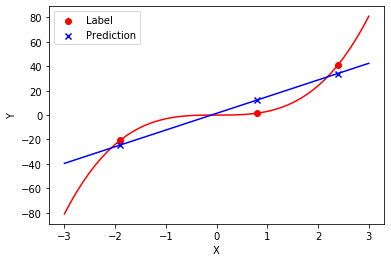

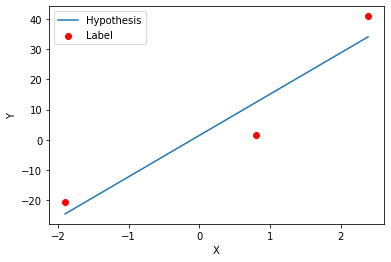

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial

class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn()
        self.w = np.random.randn(n_features) # initialise vector of features

    def __call__(self, X): #input is of shape (n_datapoints, n_vars)
        y_hat = np.matmul(X, self.w) + self.b # make linear prediction (weighted sum of features plus bias)
        return y_hat #output is of shape (n_datapoints, 1)
    
    def update_params(self, new_w, new_b):
        self.w = new_w # 
        self.b = new_b
    
    def calc_deriv(self, X, y_hat, labels):
        diffs = y_hat - labels # compute error
        dLdw = 2 * np.array([np.sum(diffs * X[:, i]) / m for i in range(self.n_features)]) # compute rate of change of loss wrt w 
        dLdb = 2 * np.sum(diffs)/m # compute rate of change of loss wrt b
        return dLdw, dLdb
                           
def train(num_epochs, X, Y, H):
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
                           
def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([X, *[np.power(X, i) for i in range(2, order + 1)]]).T # add other powers of x as features in our dataset
    return new_dataset # new_dataset should be shape [m, order]
            
_range = 3
data = np.linspace(-_range, _range, 50) # input domain is 50 points from -range to +range

m = 3 # how many examples do we want?
X = np.random.choice(data, size=(m,)) # randomly sample from our dataset
true_coeffs = (0, 0, 0, 3) # true coefficients of the function which we will sample from
Y_fn = np.polynomial.polynomial.Polynomial(true_coeffs) # returns a callable function which will evaluate the polynomial at the argument provided
Y = Y_fn(X) # compute ground truth outputs for the function evaluated at X
print('X:',X, '\n')
print('Y:',Y, '\n')   

num_epochs = 1000
learning_rate = 0.01
highest_order_power = 1

x_data = create_polynomial_inputs(X, highest_order_power) # create polynomial features of data 
print(x_data)
H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    
train(num_epochs, x_data, Y, H) # train model and plot cost curve

fig = plt.figure()
plt.scatter(X, Y, c='r', label='Label') # scatter plot the true labels 
plt.plot(data, Y_fn(data), c='r') # plot the true function
plt.scatter(X, H(x_data), c='b', label='Prediction', marker='x') # scatter plot the predictions
plt.plot(data, H(data.reshape(len(data), 1)), c='b') # plot hypothesis
plt.legend() # add plot legend
plt.xlabel('X') # give y axis label
plt.ylabel('Y') # give y axis label
plt.show() # show the plot

In this case, our model is biased to modelling a linear function, when in reality the true function is not linear, it's curved.



### What is bias?



> Bias is defined as the expected difference between the parameters that we learn, and the true parameters that define the data generating function.

<p align=center><img width=1000 src=images/NN1_bias.JPG></p>



### Underfitting - what's wrong with bias



Biased models are not optimising for the right thing. Even their best parameterisation based on the objective will not be optimal. Bias is a result of a model not having a high enough capacity to represent the necessary function.



### Symptoms of bias



- model training loss plateaus
- test performance stops improving with more training

<p align=center><img width=900 src=images/bias-syms.jpg></p>



### What can we do about bias?



- Use a model with a greater capacity
- Change our objective function



### Visualising bias



Of course in real life we have no way to know the parameters of the data generating function, but in this case we defined that function and we do know them - so we can quantitatively calculate the bias as an example.

<p align=center><img width=900 src=images/computing-bias.jpg></p>

Let's run the code cell below to compute the bias of our model (remember we can only do this because we made the fake data and know it's true parameterisation).

In [9]:
params = np.array([np.append(H.b, H.w)])

def compute_bias(my_params, true_params):
    """Compares your model's parameter vector with the data generating parameter vector and computes the bias in the model"""
    
    # MAKE PARAM VECTORS THE SAME LENGTH SO THE MATH WORKS
    if my_params.shape[1] < len(true_params): # if my model doesnt have as many params as the true model
        my_params = np.append(my_params, np.zeros((my_params.shape[0], len(true_params) - my_params.shape[1])), axis=1) # pad it with zeros (assuming that the n parameters i have are coefficients of same features that the first n parameters in the data generating function multiply)
    elif my_params.shape[1] > len(true_params): # if my model has more params than are in the data generating function
        true_params = np.append(true_params, np.zeros((1, my_params.shape[1] - len(true_params)))) # pad the true params with zeros so the shape matches
    
    # COMPUTE BIAS BETWEEN PARAM VECTORS
    diffs = my_params - true_params ## compute difference between parameter vectors
    bias = np.mean(diffs) ## compute mean bias
    bias = np.abs(bias) ## we want the absolute values which tell us whether the model is biased or not, regardless of in which direction
    return bias

bias = compute_bias(params, true_coeffs)
print('BIAS:', bias)
    

BIAS: 11.038227977635275


## Variance & overfitting



Sometimes, we have the opposite problem - high variance. 

In such case our model has the capacity to model way more complex funtions than necessary. 

> This means that it can easily fit all the training examples perfectly, and furthermore that it can find many ways to do this - the variance of the different acceptable parameterisations is high. 

<p align=center><img width=1000 src=images/NN1_variance.JPG></p>



### Overfitting - what's bad about variance



Many of acceptable parametrisations will not model the function that we want and only perform well for the examples that they were trained on (while our goal is __to be good on unseen (test) data instead)__. That means that higher variance leads to worse generalisation. 

> Variance makes our models __overfit__ to the data that they were trained on.



### Symptoms of variance



- training loss continues to decrease but testing loss increases

<p align=center><img width=900 src=images/var-syms.jpg></p>



### What can we do about high variance?



- Reduce the capacity of our model
- Increase the size of our dataset
- Introduce regularization into our loss function. We cover regularisation [in this notebook](http://theaicore.com/app/training/regularisation).



### Visualising variance



Again, in practice it's very unlikely that we ever actually know the parameterisation of the data generating distribution. We only know in this case because we made it ourselves. 

The code below trains several models and then plots the function that they represent. You should see that each of the function fits the training examples well, but that they are all different. 

This highlights the variance in different acceptable models. 

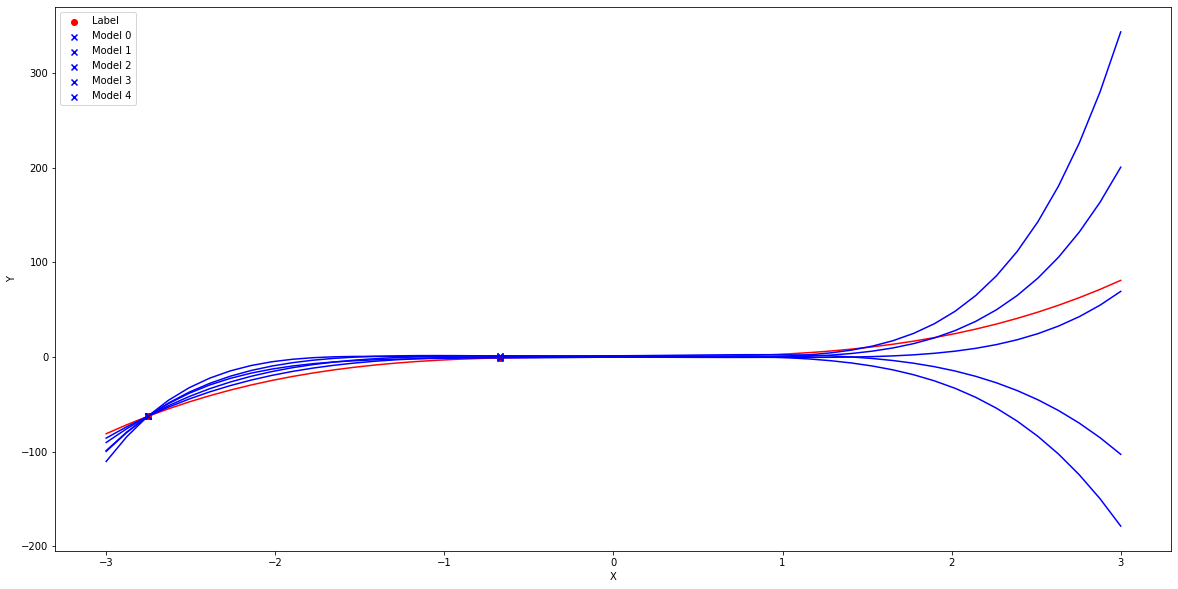

Variance: -2.960594732333751e-17


In [10]:
num_epochs = 10000
learning_rate = 0.000001
highest_order_power = 5

x_poly = create_polynomial_inputs(X, highest_order_power) # create polynomial 

fig = plt.figure(figsize=(20, 10))
plt.scatter(X, Y, c='r', label='Label')
plt.plot(data, Y_fn(data), c='r')
plt.xlabel('X')
plt.ylabel('Y')

colors = ['b', 'g', 'k', 'y']
    
def train_n_models(order, n_models=5, plot=True):
    params = []
    for i in range(n_models): # train this many models
        H = MultiVariableLinearHypothesis(n_features=order) ## initialise our model with num powers of x = order
        train(num_epochs, x_poly, Y, H) ## train model and plot cost curve
        params.append(np.append(H.b, H.w))
        if plot:
            plt.scatter(X, H(x_poly), c='b', label=f'Model {i}', marker='x')
            plt.plot(data, H(create_polynomial_inputs(data, order)), c='b')
    if plot:
        plt.legend()
        plt.show()
    return np.array(params)

def compute_variance(all_params):   
    avg_params  = np.mean(all_params, axis=0) ## compute average resulting parameters
    diffs = all_params - avg_params ## broadcast subtraction of avg params
    variance = np.mean(diffs) ## compute mean squared 
    return variance

params = train_n_models(highest_order_power)
v = compute_variance(params)
print('Variance:', v)

# might need to run the code a few times to show models with an obvious variance

As you can see, all of these functions pass through the datapoints in the training set (where circles are plotted). They fit them almost perfectly! But they do not actually represent the true input-output relationship, especially further away from examples that were seen in the training set.

## Memorization



At the end of the `variance` spectrum (this usually happens in neural networks which we'll see later) is __memorization__:

> Memorization occurs when the model internalizes whole training dataset essentially pairing `input-output` without learning anything



### Example



Let's imagine we have multiclass classification (`10` classes) and `10` examples, each of different class.

In such case our logistic regression model will __perfectly__ fit the training dataset by memorizing each example (setting weights exactly how they should be).

> If another example comes in, it will likely fail as the model failed to get any key characteristic of examples belonging to said class

## Let's compare bias, variance and generalisation for different models



Bias and variance measure two different sources of error in a model's parameterisation:
- __Bias__ - measures the error that you expect from the true parameterisation
- __Variance__ - measures the expected difference of a particular parameterisation from the averagely found parameterisation. This is a result of the particular subset of all possible examples which makes up the dataset that the model was trained on.



# bias vs variance summary



<p align=center><img width=900 src=images/b-v-grid.jpg></p>


### Generalization theory: Loss decomposition into bias and variance



$$
L_{MSE} = \mathbb{E}[( \hat{\theta}_m - \theta )^2] = Bias(\hat{\theta}_m)^2 + Var(\hat{\theta}_m)
$$



- The mean squared error of a parameter estimate can be expressed as the sum of the bias squared and the variance. 
- It is a suitable way to evaluate the optimal capacity of a model. 
- __BUT__ we need to know the true parameterisation of the data generating function to compute the bias and variance 
- __This cannot be done in practice__ but gives us an idea how it works in real world

The code below trains multiple polynomial models which include terms for successively larger powers of x. 

For each, we calculate the bias and variance using the true parameterisation of the data generating function. We will train each of these model several times to get an average and plot mean squared error:

order:  1
order:  2
order:  3
order:  4
order:  5
order:  6
order:  7
order:  8


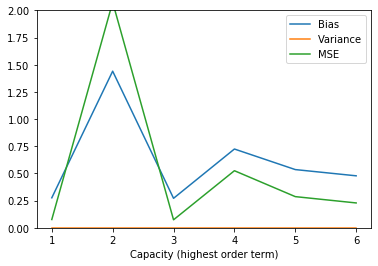

In [11]:
poly_orders = 9
num_models = 5

all_parameters = [] # will use this in the next code cell

orders = list(range(1, poly_orders))
biases = []
variances = []
for order in orders:
    print('order: ', order)
    if order > 1:
        x_poly = create_polynomial_inputs(X, order) # create polynomial 
    else:
        x_poly = X.reshape(-1, 1)
    parameters = train_n_models(order, n_models=num_models, plot=False)
    biases.append(compute_bias(parameters, true_coeffs))
    variances.append(compute_variance(parameters))
    
    all_parameters.append(parameters) # will use this in the next code cell
    
plt.plot(orders, biases, label='Bias')
plt.plot(orders, variances, label='Variance')
plt.plot(orders, np.sum([variances, np.array(biases)**2], axis=0), label='MSE')
plt.xlabel('Capacity (highest order term)')
plt.ylim(0, 2)
plt.legend()
plt.show()

The graph above should show that the model with the minimum mean squared error in the estimate of the true parameters is that which includes x-terms up to $x^3$. This indicates that we should use a cubic model, which makes sense beacause we created our data from a cubic function.

If we smoothed the above graph it should look something like that shown below.

<p align=center><img width=900 src=images/g-gap.jpg></p>


- We build machine learning algorithms to make predictions. The real measure of success in machine learning is when we can make correct predictions for samples that the model has not seen yet.
- We already know that models with high bias or high variance aren't good because they either underfit or overfit the data. This means that they will not **generalise** to perform well on new examples - they have high **generalisation error**.
- Because the mean squared error incorporates both bias and variance, it should be a measure of this generalisation error.

Let's add to the above code to not only train the models but also to compute their generalisation ability.

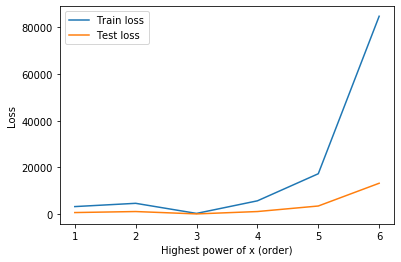

In [12]:
def Loss(y_hat, y):
    return np.sum((y_hat - y)**2) / len(y_hat)

def train_and_test(params_list):
    train_data = np.random.choice(data, size=(3,)) # randomly sample from data
    test_data = np.random.choice(data, size=(100,))
    train_losses = []
    test_losses = []

    for order, params in enumerate(params_list): # for each of the previously trained parameters

        # params = np.mean(params, axis=0) # compute mean of parameters predicted for this model
        params = params[0] # or just use the first one

        h = np.polynomial.polynomial.Polynomial(params) # create polynomial function

        h_train = h(train_data) # make prediction on training data
        train_loss = Loss(h_train, Y_fn(train_data)) # compute training loss
        train_losses.append(train_loss)

        h_test = h(test_data) # make prediction on test data
        test_loss = Loss(h_test, Y_fn(test_data)) # compute test loss
        test_losses.append(test_loss)

    plt.plot(orders, train_losses, label='Train loss')
    plt.plot(orders, test_losses, label='Test loss')
    plt.legend()
    plt.xlabel('Highest power of x (order)')
    plt.ylabel('Loss')
    plt.show()
        
        
train_and_test(all_parameters)

You should see that the test loss is best (lowest) for the cubic model. Again this makes sense, as our data generating function is cubic.

## Assessments

- Read more about bias and variance decomposition [for example on wiki](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) and see for what else one could apply it (except MSE)
- What is noise and how does it mix with MLE? 
- Is the noise inherent to data? What source might it come from?
- Read about [one shot learning](https://en.wikipedia.org/wiki/One-shot_learning)

## Summary

- Bias is defined as the expected difference between the parameters that we learn, and the true parameters that define the data generating function.
- We have a problem with __bias__ when our model is too simple and it's function is incapable of modeling our data which is called __underfitting__
- Variance is when our model can go for more complicated functions than required
- This leads to __overfitting__ on training dataset and provides __poor generalization__ despite __low training error__
- Memorization problem might happen if we don't have enough data or we have a very strong model. It means model "remembers" training dataset instead of learning it's key characteristics, hence the generalization does not happen